# Error Propagation using Random Gaussian Numbers

Example calculation of propagating uncertainties, both when adding and multiplying number, and also in the general case. The propagation can be done both analytically (using the error propagation formula) and also using simulation.

The example is based on FIRST doing the error propagation **analytically**, and then verifying it by running a so-called Monte-Carlo (MC) program, which uses random numbers for propagating errors.

## References:
- Barlow: page 48-61
- Bevington: page 36-48

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   8th of November 2022

***

DO THE FOLLOWING ANALYTICAL EXERCISE FIRST!!!

1. A class of students estimate by eye, that the length of the table in Auditorium A is $L = (3.5\pm 0.4)$ m, and that the width is $W = (0.8\pm 0.2)$ m.

   Assuming that there is no correlation between these two measurements, calculate ANALYTICALLY what the Perimeter (P), area (A), and diagonal (D) length is including (propagated) uncertainties. Repeat the calculation, given that the correlation between length and width is $\rho(L,W) = 0.5$ - not an unreasonable number, given that they are estimated by the same (uncertain) scale.
   
NOTE: This is a complete standard problem, that you will be asked to solve again and again in the course. For this reason, make sure that you understand how to do it, and become good at doing it reasonably fast.


In [131]:
import sympy as sp # import the sympy library

# define the variables
L , W , P , A , D , rho = sp.symbols('L W P A D rho')

L=3.5 # m
W=0.8 # m

# define the equation
P = 2*L + 2*W                  # perimeter
A = L*W                        # area
D = sp.sqrt(L**2 + W**2)       # diagonal


# define uncertainty
dL = 0.4
dW = 0.2

#calculate the uncertainty
dP = sp.sqrt((2*dL)**2 + (2*dW)**2)
dA = sp.sqrt((dL*W)**2 + (L*dW)**2)
dD = sp.sqrt((dL/(2*D))**2 + (dW/(2*D))**2)


# print the results
print('Results for rho = 0 :')
print('P = ', P, ' +/- ', dP)   # perimeter
print('A = ', A, ' +/- ', dA)   # area
print('D = ', D, ' +/- ', dD)   # diagonal

# calculate correlated uncertainty
rho = 0.5
dP = sp.sqrt((2*dL)**2 + (2*dW)**2 + 2*rho*2*dL*2*dW)                # perimeter
dA = sp.sqrt((dL*W)**2 + (L*dW)**2 + 2*rho*dL*W*dW*L)                # area
dD = sp.sqrt((dL/(2*D))**2 + (dW/(2*D))**2 + 2*rho*dL*dW/(2*D**2))   # diagonal


# print the results
print('Results for rho = 0.5 :')
print('P = ', P, ' +/- ', dP)   # perimeter
print('A = ', A, ' +/- ', dA)   # area
print('D = ', D, ' +/- ', dD)   # diagonal


Results for rho = 0 :
P =  8.6  +/-  0.894427190999916
A =  2.8000000000000003  +/-  0.769675256195754
D =  3.59026461420325  +/-  0.0622814254039606
Results for rho = 0.5 :
P =  8.6  +/-  1.05830052442584
A =  2.8000000000000003  +/-  0.903548559846121
D =  3.59026461420325  +/-  0.0835593005633029


In [132]:
# Defining the parameters:
mu1   =  3.5
sig1  =  0.4
mu2   =  0.8
sig2  =  0.2
rho12 =  0.5           # Correlation parameter!

In [133]:
if not (-1.0 <= rho12 <= 1.0): 
    raise ValueError(f"Correlation factor not in interval [-1,1], as it is {rho12:6.2f}")

### Note on analytic solutions:

Python includes symbolic algebra in the package *SymPy*, which is both simple and powerful (and in Python). In addition, printing with Latex can also be included (see below), which (in combination) is very nice.

Below is a SymPy and Latex example with the hope that it will wet your appetite.

In [134]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [135]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
L,W,P,A,D = symbols("L, W, P, A, D")
dL,dW,dP,dA,dD = symbols("sigma_L, sigma_W, sigma_P, sigma_A, sigma_D")

# Perimeter:
# Define relation, and print:
P = 2*L + 2*W
lprint(latex(Eq(symbols('P'),P)))

# Calculate uncertainty and print:
dP = sqrt((P.diff(L) * dL)**2 + (P.diff(W) * dW)**2)
lprint(latex(Eq(symbols('sigma_P'), dP)))

# Turn expression into numerical functions 
fP = lambdify((L,W),P)
fdP = lambdify((L,dL,W,dW),dP)

# Define values and their errors
vL, vdL = mu1,sig1
vW, vdW = mu2,sig2

# Numerically evaluate expressions and print 
vP = fP(vL,vW)
vdP = fdP(vL,vdL,vW,vdW)
lprint(fr'P = ({vP:.1f} \pm {vdP:.1f})\,\mathrm{{m}}')




# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [136]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories

In [137]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

## Error propagation - Simulation

Now we want to try to see, if we can solve the above error propagation problem using simulation. The method is relatively straight forward: You simply take "realistic" values of the input parameters x (here Length (x1) and Width (x2)), calculate the resulting value y (here Perimeter, Area, and Diagonal), and do this many times. The resulting distribution of y should be centered around the value y(x1,x2), and the standard deviation should reflect the uncertainty in y from the uncertainties in the input variables.

This is a much more clumsy way of calculating the uncertainty, but comes with the advantage, that if the resulting uncertainty is not Gaussian, then one can actually see this (i.e. it avoids the assumptions used in the usual error propagation formula).

In [138]:
# First we set the parameters of the program:
N_exp = 100000           # Number of "experiments" (i.e. drawing from random distributions)
save_plots = False
r = np.random
r.seed(42)

Define parameters for two random numbers (Gaussianly distributed):

In [139]:
mu1   =  3.5
sig1  =  0.4
mu2   =  0.8
sig2  =  0.2
rho12 =  0.5           # Correlation parameter!

In [140]:
if not (-1.0 <= rho12 <= 1.0): 
    raise ValueError(f"Correlation factor not in interval [-1,1], as it is {rho12:6.2f}")

Now we calculate numbers that allows the transform from uncorrelated variables `u` and `v` to correlated random numbers `x1` and `x2` below (see Barlow page 42-44 for method).

Essentially, the method is to "rotate" `u` and `v`, and the formulae simply controls the amount of rotation one needs to get the correlation wanted.

In [141]:
# Define the parameters needed for the transformation:
theta = 0.5 * np.arctan( 2.0 * rho12 * sig1 * sig2 / ( np.square(sig1) - np.square(sig2) ) )
sigu = np.sqrt( np.abs( (((sig1*np.cos(theta))**2) - (sig2*np.sin(theta))**2 ) / ( (np.cos(theta))**2 - np.sin(theta)**2) ) )
sigv = np.sqrt( np.abs( (((sig2*np.cos(theta))**2) - (sig1*np.sin(theta))**2 ) / ( (np.cos(theta))**2 - np.sin(theta)**2) ) )

# Produce random numbers with the (possible) correlation:
u = r.normal(0.0, sigu, N_exp)
v = r.normal(0.0, sigv, N_exp)
x1_all = mu1 + np.cos(theta)*u - np.sin(theta)*v
x2_all = mu2 + np.sin(theta)*u + np.cos(theta)*v
x12_all = np.array([x1_all, x2_all])

y_all = x1_all - 2*x2_all         # Silly formula - you have to put this in yourself!

P_all = 2*x1_all + 2*x2_all              # perimeter
A_all = x1_all*x2_all                    # area
D_all = np.sqrt(x1_all**2 + x2_all**2)   # diagonal

Note that the above is nothing more than a matrix multiplication written out! Also note that the absolute value is taken before the square root to avoid `np.sqrt(x)` with `x<0`.

***
Plot both input distribution and resulting 2D-histogram on screen:

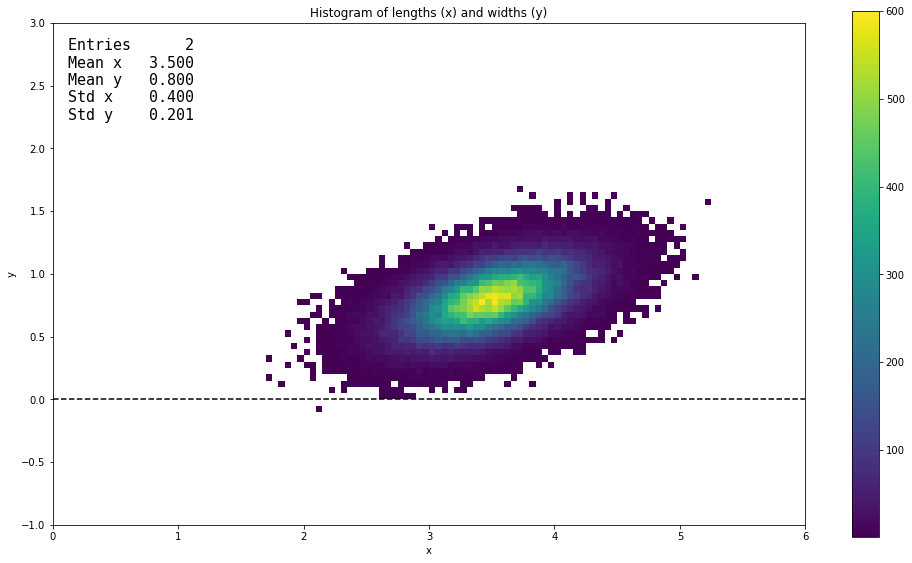

In [142]:
fig, ax = plt.subplots(figsize=(14, 8))
counts, xedges, yedges, im = ax.hist2d(x1_all, x2_all, bins=[120, 80], range=[[0.0, 6.0], [-1.0, 3.0]], cmin=1)
ax.plot([0.0, 6.0], [0.0, 0.0], "--k")   # NOTE: This draws a line from [x1, x2], [y1, y2] with dashed line ("--") and in black ("k")
fig.colorbar(im) # ticks=[-1, 0, 1]

ax.set(title='Histogram of lengths (x) and widths (y)',
       xlabel='x', 
       ylabel='y',
       aspect='equal', # NOTE: This forces the x- and y-axis to have the SAME scale!!!
      )

d = {'Entries': len(x12_all),
     'Mean x': x1_all.mean(),
     'Mean y': x2_all.mean(),
     'Std x': x1_all.std(ddof=1),
     'Std y': x2_all.std(ddof=1),
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=15);

fig.tight_layout()
fig

if save_plots :
    fig.savefig("Dist_2Dgauss.pdf")

Now we bin `y_all` and fit it with a Gaussian distribution:

In [143]:
def gaussian(x, N, mu, sigma):
    return N * binwidth / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2)

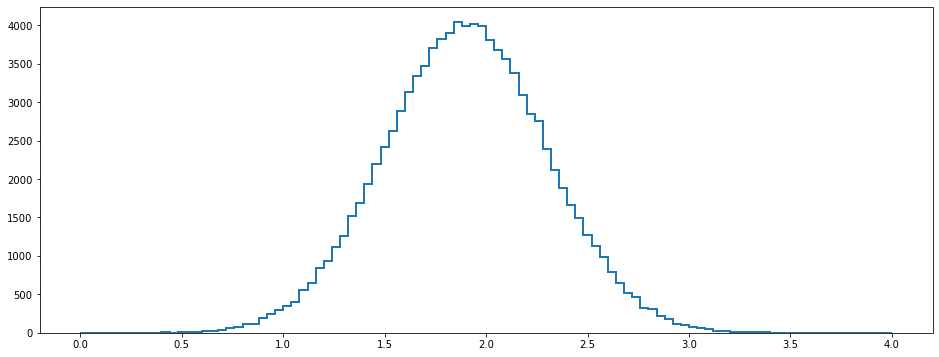

In [144]:
nbins = 100
xmin, xmax = 0.0, 4.0
binwidth = (xmax-xmin)/nbins

fig2, ax2 = plt.subplots(figsize=(16, 6));
counts, bin_edges, _ = ax2.hist(y_all, nbins, range=(xmin, xmax), histtype='step', linewidth=2)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

This is the distribution of "whatever you put into it" (initially x1-2*x2), which shows what output you get and what uncertainty to expect (given by the width - think about this!). We can thus get the result by simply recording the mean and width (SD):

In [145]:
mean = y_all.mean()
std = y_all.std(ddof=1)
print(f"  Mean = {mean:5.3f},    Std = {std:5.3f}")

P_mean = P_all.mean()
P_std = P_all.std(ddof=1)
print(f"  P_Mean = {P_mean:5.3f},    P_Std = {P_std:5.3f}")

A_mean = A_all.mean()
A_std = A_all.std(ddof=1)
print(f"  A_Mean = {A_mean:5.3f},    A_Std = {A_std:5.3f}")

D_mean = D_all.mean()
D_std = D_all.std(ddof=1)
print(f"  D_Mean = {D_mean:5.3f},    D_Std = {D_std:5.3f}")

  Mean = 1.900,    Std = 0.399
  P_Mean = 8.601,    P_Std = 1.061
  A_Mean = 2.842,    A_Std = 0.911
  D_Mean = 3.595,    D_Std = 0.414


However, we are in principle not even sure, if this distribution is Gaussian, so in order to check this, we draw a Gaussian on top using the above mean and standard deviation values.

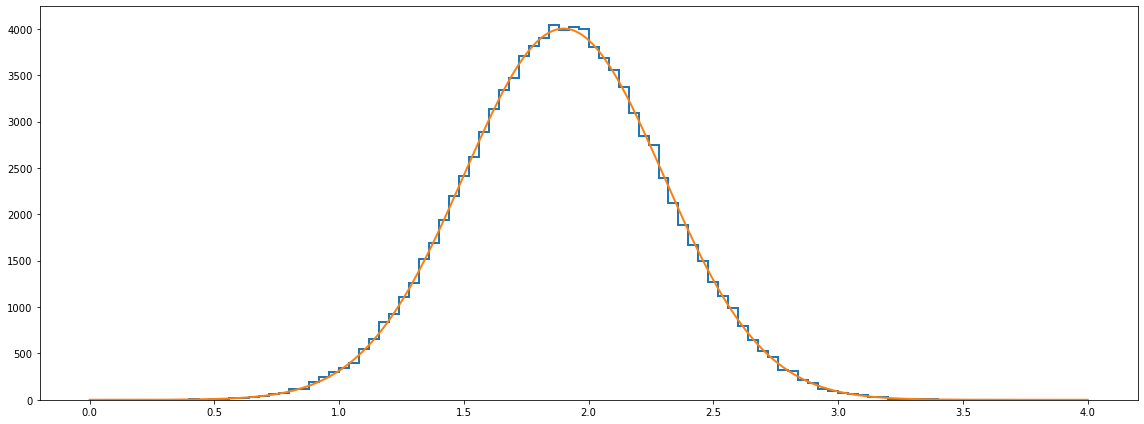

In [146]:
xaxis = np.linspace(xmin, xmax, 1000)
yaxis = gaussian(xaxis, N_exp, mean, std)
ax2.plot(xaxis, yaxis, linewidth=2)
fig2.tight_layout()
fig2

In [147]:
if save_plots:
    fig2.savefig("Dist_ErrorProp.pdf")

In [148]:
#Question 2.1 - ANALYTICAL SOLUTION

y1 , y2 , x1, x2 , dy1 , dy2 , dx1 , dx2 = sp.symbols('y1 y2 x1 x2 dy1 dy2 dx1 dx2')

y1 = sp.log((x1*tan(x2))**2+((x1-x2)/(sp.cos(x2)+1.0+x1))**2)  
y2 = 1.1+sp.sin(20*x1)

#partial derivatives
dy1_dx1 = sp.diff(y1,x1)
dy1_dx2 = sp.diff(y1,x2)
dy2_dx1 = sp.diff(y2,x1)
dy2_dx2 = sp.diff(y2,x2)

#error propagation

dy1 = sp.sqrt((dy1_dx1*dx1)**2+(dy1_dx2*dx2)**2)
dy2 = sp.sqrt((dy2_dx1*dx1)**2+(dy2_dx2*dx2)**2)

# Turn expression into numerical functions 
y1 = sp.lambdify((x1,x2), y1, "numpy")
y2 = sp.lambdify((x1,x2), y2, "numpy")
dy1 = sp.lambdify((x1,x2,dx1,dx2),dy1)
dy2 = sp.lambdify((x1,x2,dx1,dx2),dy2)

#Solving equations using given values for x1=L, x2=W and dx1=dL, dx2=dW
L=3.5 
W=0.8 
dL = 0.4
dW = 0.2

central_y1 = y1(L,W)
central_y2 = y2(L,W)
sigma_y1 = dy1(x1=L,x2=W,dx1=dL,dx2=dW)
sigma_y2 = dy2(x1=L,x2=W,dx1=dL,dx2=dW)

lprint(fr'y1 = ({central_y1:.1f} \pm {sigma_y1:.1f})\,\mathrm{{m}}')
lprint(fr'y2 = ({central_y2:.1f} \pm {sigma_y2:.1f})\,\mathrm{{m}}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

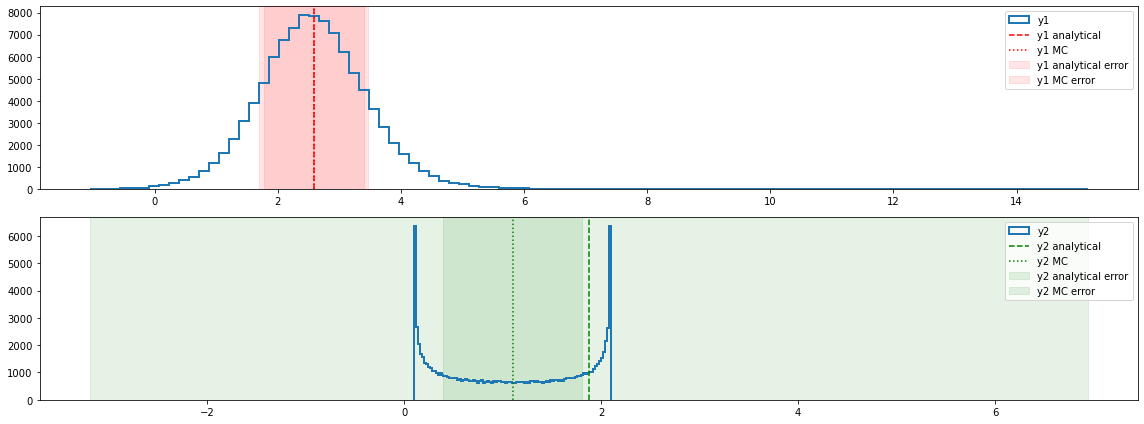

In [161]:
#Question 2.2 - MONTE CARLO SIMULATION

#Generate random numbers for x1 and x2
x1 = np.random.normal(L,dL,N_exp)
x2 = np.random.normal(W,dW,N_exp)

#Calculate y1 and y2
y1_distribution = y1(x1,x2)
y2_distribution = y2(x1,x2)

#Calculate the mean and standard deviation of y1 and y2
y1_mean = np.mean(y1_distribution)
y2_mean = np.mean(y2_distribution)
y1_std = np.std(y1_distribution,ddof=1)
y2_std = np.std(y2_distribution,ddof=1)

#Print the results
lprint(fr'y1 = ({y1_mean:.1f} \pm {y1_std:.1f})\,\mathrm{{m}}')
lprint(fr'y2 = ({y2_mean:.1f} \pm {y2_std:.1f})\,\mathrm{{m}}')

# #Question 2.3 - COMPARISON

#Plot the results
fig3, [ax2,ax3] = plt.subplots(2,1,figsize=(16, 6));
ax2.hist(y1_distribution, bins=100, histtype='step', linewidth=2, label='y1')
ax3.hist(y2_distribution, bins=100, histtype='step', linewidth=2, label='y2')
ax2.axvline(central_y1, color='r', linestyle='--', label='y1 analytical')
ax3.axvline(central_y2, color='g', linestyle='--', label='y2 analytical')
ax2.axvline(y1_mean, color='r', linestyle=':', label='y1 MC')
ax3.axvline(y2_mean, color='g', linestyle=':', label='y2 MC')
ax2.axvspan(central_y1-sigma_y1, central_y1+sigma_y1, color='r', alpha=0.1, label='y1 analytical error')
ax3.axvspan(central_y2-sigma_y2, central_y2+sigma_y2, color='g', alpha=0.1, label='y2 analytical error')
ax2.axvspan(y1_mean-y1_std, y1_mean+y1_std, color='r', alpha=0.1, label='y1 MC error')
ax3.axvspan(y2_mean-y2_std, y2_mean+y2_std, color='g', alpha=0.1, label='y2 MC error')
ax3.legend(), ax2.legend()
fig3.tight_layout() 




---

# Questions:

0. First solve the problem of obtaining the Perimeter, Area & Diagonal with uncertainty ANALYTICALLY.

1. Now look at the program, and assure yourself that you understand what is going on. Put in the correct expression for y in terms of x1=L and x2=W in order to calculate the perimeter, area, and diagonal length, and run the program. Does the output correspond well with the results you expected from your analytical calculations to begin with?

2. Imagine that you wanted to know the central value and uncertainty of y1 and y2, given the
   same above PDFs for `x1`=$L$ and `x2`=$W$:
   
     `y1 = log(square(x1*tan(x2))+sqrt((x1-x2)/(cos(x2)+1.0+x1)))`
     
     `y2 = 1.1+sin(20*x1)`

   Get the central value of y, and see if you can quickly differentiate this with
   respect to `x1` and `x2`, and thus predict what uncertainty to expect for y using
   the error propagation formula. It is (for once) OK to give up on the first expression :-)
   Next, try to estimate the central value and uncertainty using random numbers
   like above - do you trust this result more? And are the distributions Gaussian?


### Advanced questions:

3. Try to generate `x1` and `x2` with non-linear correlation, which yields zero linear correlation,
   and see that despite not having any linear correlation, the result on perimeter, area, and diagonal
   length is still affected.


# Learning points:

Through this exercise, you should understand, that uncertainties (errors in slang) propagation can be in **two ways**:
1. **Analytically**, propergating the uncertainties by differentiating the formula/relation in question.
2. **Numerically** (i.e. simulation), by using random numbers reflecting the uncertainties on the input parameters, and calculating the final resulting number many times from these, noting the variation.

The analytical method is simple and transparent, but not always robust, as it requires that the error propagation formula holds. The numerical method is simple and robust, but not transparent. Using both methods is a great way of cross checking.

Finally, you should understand, that error propagation plays an essential role in science, and that it is also used in planning of experiments (to minimise the error on the final quantity of interest).